In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# obtain data
from torchvision import datasets, transforms

# PATH_OF_DATA = "/content/drive/My Drive/APS360/Emotion_Detection_CNN"
PATH_OF_DATA = "/Users/kexinli/PycharmProjects/RECTnet"

In [4]:
###############################################################################

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        #print(label_index)
        label_class = classes[label_index] # ex: 'A'
        if label_class in target_classes:
            indices.append(i)
    return indices


def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [27]:
def get_data_loader(data_path, target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:

        data_path: Path of the data
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('0', '1', '2', '3', '4', '5', '6')

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    torch.manual_seed(1000)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_set = torchvision.datasets.ImageFolder(root= data_path+"/dataset_train", transform = transform)
    val_set = torchvision.datasets.ImageFolder(root= data_path+"/dataset_valid", transform = transform)
    test_set = torchvision.datasets.ImageFolder(root= data_path+"/dataset_test", transform = transform)
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            val_set,
            classes,
            target_classes)
    
    np.random.shuffle(relevant_train_indices)
    split1 = int(len(relevant_train_indices) * 0.6)
    split2 = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_train_indices[:split1], relevant_train_indices[split1:split2], relevant_train_indices[split2:]
    
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    #print("length of train data: {}".format(len(train_loader)))
    return train_loader, val_loader, test_loader, classes

In [28]:
def get_accuracy(model, data, train=False):

    correct = 0
    total = 0
    #for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
    for imgs, labels in data: 
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [29]:
def train(model, data_path, batch_size=64, learning_rate=0.01, num_epochs=1):
    target_classes = ['0', '1', '2', '3', '4', '5', '6']
    train_feature, val_feature, test_feature = get_feature_loader(batch_size)
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # print(model.parameters())
    iters, viters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    m = 0
    for epoch in range(num_epochs):
        train_loss_tot = 0
        val_loss_tot = 0
        train_item = 0
        val_item = 0
        print("Starting epoch ", epoch)

        for features, labels in iter(train_feature):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            train_loss_tot += loss
            train_item += 1
            iters.append(n)
            n += 1

              
        for features, labels in iter(val_feature):
           #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            val_loss_tot += loss
            val_item += 1
            viters.append(m)
            m += 1
              
        # save the training info for every few (1) epoches:
        #iters.append(n)
        train_losses.append(float(train_loss_tot)/train_item)             # compute *average* loss
        get_acc = get_accuracy(model, train_feature)
        train_acc.append(get_acc) # compute training accuracy 

        val_losses.append(float(val_loss_tot)/val_item)             # compute *average* loss
        get_acc_val = get_accuracy(model, val_feature)
        val_acc.append(get_acc_val)  # compute validation accuracy

        #print("Iter {}: ".format(n))
        print("Train loss: {}, Train acc: {}".format(float(train_loss_tot)/train_item, get_acc))
        print("Validation loss: {}, Validation acc: {}".format(float(val_loss_tot)/val_item, get_acc_val))
  
        # (checkpoint)
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)  
        # for plotting later (checkpoint)
        np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_losses)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)      
    print("Finished training")


def plot_training_curve(path):
    import matplotlib.pyplot as plt

    train_losses = np.loadtxt("{}_train_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_losses = np.loadtxt("{}_val_loss.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))

    plt.title("Training Curve")

    n = len(train_losses)
    m = len(val_losses)
    # print(n, m)
    plt.plot(range(1, n + 1), train_losses, label="Train")
    plt.plot(range(1, m + 1), val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, n + 1), train_acc, label="Train")
    plt.plot(range(1, m + 1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [30]:
# import torchvision.models
# torchvision.models.inception.inception_v3(pretrained=True)
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [31]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
def dataset_to_features(data_set):
  feature_set = []
  for imgs, labels in data_set:
    features = alexnet.features(imgs)
    features = torch.from_numpy(features.detach().numpy())
    feature_set.append((features, labels))
  return feature_set

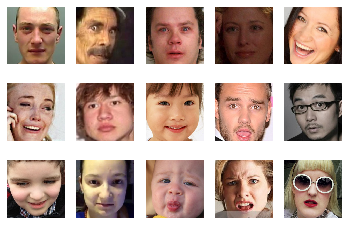

In [21]:
# test if works
train_loader, val_loader, test_loader, classes = get_data_loader( 
    PATH_OF_DATA,
    target_classes = ['0', '1', '2', '3', '4', '5', '6'], 
    batch_size=1)


k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [36]:
def get_feature_loader(data_path, batch_size=1):
  train_loader, val_loader, test_loader, classes = get_data_loader( 
      PATH_OF_DATA,
      target_classes = ['0', '1', '2', '3', '4', '5', '6'], 
      batch_size=batch_size)
  train_feature = dataset_to_features(train_loader)
  val_feature = dataset_to_features(val_loader)
  test_feature = dataset_to_features(test_loader)
  return train_feature, val_feature, test_feature

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
# master_path = '/content/drive/My Drive/APS360/Emotion_Detection_CNN'
master_path = '/Users/kexinli/PycharmProjects/RECTnet'
# Prepare Dataloader (requires code from 1.)
train_loader, val_loader, test_loader, classes = get_data_loader( 
      PATH_OF_DATA,
      target_classes = ['0', '1', '2', '3', '4', '5', '6'], 
      batch_size=1)
print("so far so good")
target_classes = ['0', '1', '2', '3', '4', '5', '6']

# save features to folder as tensors
n = 0
for img, label in train_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/dataset_train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), master_path + '/dataset_train/' + '/tensor/' + str(n) + '.tensor')
  n += 1
print("--------------------------------------")
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/dataset_valid/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), master_path + '/dataset_valid/' + '/tensor/' + str(n) + '.tensor')
  n += 1
print("======================================")
for img, label in test_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/dataset_test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), master_path + '/dataset_test/' + '/tensor/' + str(n) + '.tensor')
  n += 1

so far so good
--------------------------------------


In [33]:
def get_feature_loader(batch_size):
  master_path = '/Users/kexinli/PycharmProjects/RECTnet'
  train_set = torchvision.datasets.DatasetFolder(master_path+"/dataset_train/tensor", loader=torch.load, extensions=('.tensor'))
  val_set = torchvision.datasets.DatasetFolder(master_path+"/dataset_valid/tensor", loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(master_path+"/dataset_test/tensor", loader=torch.load, extensions=('.tensor'))

  train_feature = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
  val_feature = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
  test_feature = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
  return train_feature, val_feature, test_feature

In [58]:
class FaceRec(nn.Module):
      def __init__(self):
          super(FaceRec, self).__init__()
          self.name = "FaceRec"
          self.conv1 = nn.Conv2d(256, 100, 3) #in_channels, out_chanels, kernel_size
          #self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
         # self.conv2 = nn.Conv2d(128, 10, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(9216, 50)
          self.fc2 = nn.Linear(50, 7)

      def forward(self, x):
          # print (x.shape)
         # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 9216)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          
          return x

In [62]:
# training
use_cuda = True
model = FaceRec()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, PATH_OF_DATA, batch_size=64, learning_rate=0.0002, num_epochs=20)

CUDA is not available.  Training on CPU ...
Starting epoch  0
Train loss: 1.8841382998511904, Train acc: 0.35523809523809524
Validation loss: 1.7242961774553571, Validation acc: 0.3028571428571429
Starting epoch  1
Train loss: 1.6973341006324405, Train acc: 0.4014285714285714
Validation loss: 1.717174595424107, Validation acc: 0.3357142857142857
Starting epoch  2
Train loss: 1.5662327938988094, Train acc: 0.42857142857142855
Validation loss: 1.8534575544084821, Validation acc: 0.3457142857142857
Starting epoch  3
Train loss: 1.4148429361979167, Train acc: 0.4738095238095238
Validation loss: 1.933105991908482, Validation acc: 0.3485714285714286
Starting epoch  4
Train loss: 1.273635486421131, Train acc: 0.5404761904761904
Validation loss: 2.008743896484375, Validation acc: 0.3457142857142857
Starting epoch  5
Train loss: 1.178807082403274, Train acc: 0.5452380952380952
Validation loss: 2.0037845284598212, Validation acc: 0.32285714285714284
Starting epoch  6
Train loss: 1.06197567894345

In [ ]:
model_path = get_model_name("FaceRec", batch_size=64, learning_rate=0.0002, epoch=19)
plot_training_curve(model_path)

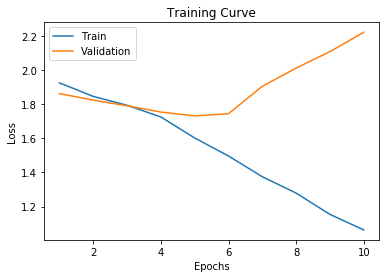

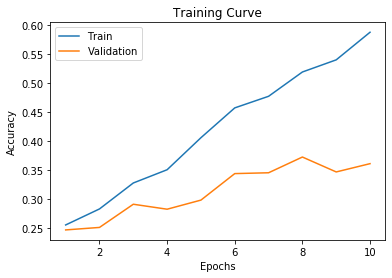

Final Training Loss: 1.0631839425223215
Final Validation Loss: 2.2200202287946427
Final Training Accuracy: 0.5880952380952381
Final Validation Accuracy: 0.36142857142857143


In [61]:
model_path = get_model_name("FaceRec", batch_size=64, learning_rate=0.0002, epoch=9)
plot_training_curve(model_path)

In [66]:
# training
use_cuda = True
model = FaceRec()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, PATH_OF_DATA, batch_size=64, learning_rate=0.0002, num_epochs=15)

CUDA is not available.  Training on CPU ...
Starting epoch  0
Train loss: 1.8841382998511904, Train acc: 0.35523809523809524
Validation loss: 1.7242961774553571, Validation acc: 0.3028571428571429
Starting epoch  1
Train loss: 1.6973341006324405, Train acc: 0.4014285714285714
Validation loss: 1.717174595424107, Validation acc: 0.3357142857142857
Starting epoch  2
Train loss: 1.5662327938988094, Train acc: 0.42857142857142855
Validation loss: 1.8534575544084821, Validation acc: 0.3457142857142857
Starting epoch  3
Train loss: 1.4148429361979167, Train acc: 0.4738095238095238
Validation loss: 1.933105991908482, Validation acc: 0.3485714285714286
Starting epoch  4
Train loss: 1.273635486421131, Train acc: 0.5404761904761904
Validation loss: 2.008743896484375, Validation acc: 0.3457142857142857
Starting epoch  5
Train loss: 1.178807082403274, Train acc: 0.5452380952380952
Validation loss: 2.0037845284598212, Validation acc: 0.32285714285714284
Starting epoch  6
Train loss: 1.06197567894345

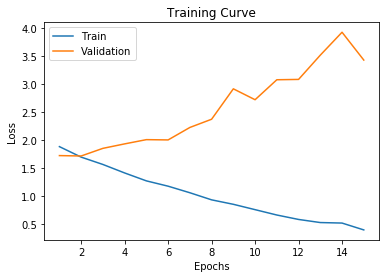

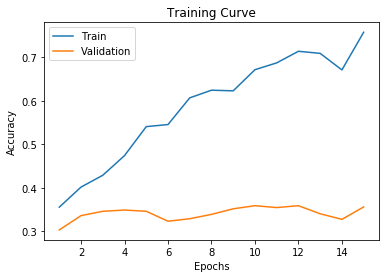

Final Training Loss: 0.399224359421503
Final Validation Loss: 3.42741943359375
Final Training Accuracy: 0.7576190476190476
Final Validation Accuracy: 0.3557142857142857


In [67]:
model_path = get_model_name("FaceRec", batch_size=64, learning_rate=0.0002, epoch=14)
plot_training_curve(model_path)

In [68]:
# testing
use_cuda = True
train_feature, val_feature, test_feature = get_feature_loader(1)

test_accuracy = get_accuracy(model, test_feature)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.3557142857142857


Previous dataset results: on small dataset

In [0]:
# training
use_cuda = True
model = FaceRec()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, PATH_OF_DATA, batch_size=64, learning_rate=0.002, num_epochs=50)

CUDA is not available.  Training on CPU ...
Starting epoch  0
Train loss: 1.9527210235595702, Train acc: 0.14285714285714285
Validation loss: 1.9499634504318237, Validation acc: 0.15306122448979592
Starting epoch  1
Train loss: 1.941268539428711, Train acc: 0.21768707482993196
Validation loss: 1.9369066953659058, Validation acc: 0.19387755102040816
Starting epoch  2
Train loss: 1.9270572662353516, Train acc: 0.272108843537415
Validation loss: 1.927945852279663, Validation acc: 0.19387755102040816
Starting epoch  3
Train loss: 1.9129018783569336, Train acc: 0.42857142857142855
Validation loss: 1.9141535758972168, Validation acc: 0.2653061224489796
Starting epoch  4
Train loss: 1.895106315612793, Train acc: 0.4421768707482993
Validation loss: 1.9000873565673828, Validation acc: 0.336734693877551
Starting epoch  5
Train loss: 1.8737785339355468, Train acc: 0.5204081632653061
Validation loss: 1.885080337524414, Validation acc: 0.3979591836734694
Starting epoch  6
Train loss: 1.849214172363

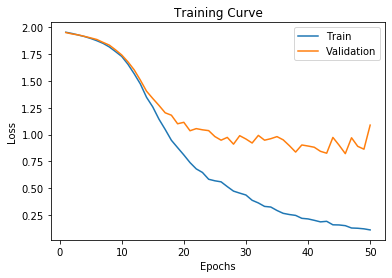

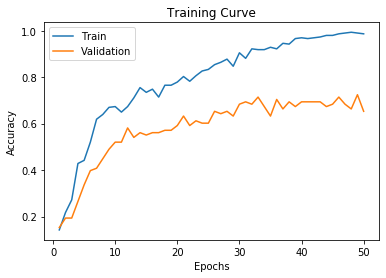

Final Training Loss: 0.11112077236175537
Final Validation Loss: 1.0874344110488892
Final Training Accuracy: 0.9863945578231292
Final Validation Accuracy: 0.6530612244897959


In [0]:
model_path = get_model_name("FaceRec", batch_size=64, learning_rate=0.002, epoch=49)
plot_training_curve(model_path)

In [0]:
# testing
use_cuda = True
train_feature, val_feature, test_feature = get_feature_loader(1)

test_accuracy = get_accuracy(model, test_feature)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.7857142857142857
